# 1. Install packages

In [1]:
!pip install tensorflow opencv-python matplotlib albumentations

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Import our packages and build image loading function

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import numpy as np

In [4]:
def load_image(image):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img)
    return img

In [5]:
images = tf.data.Dataset.list_files('drive/MyDrive/data/training/images/*.jpg', shuffle=True).map(load_image)

## Plot some training samples

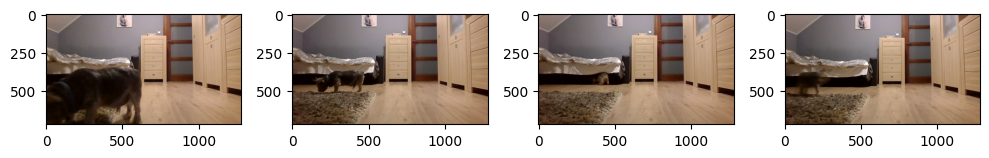

In [6]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
plot_images = plot_images / 255.0

fig, ax = plt.subplots(ncols=4, figsize=(10,10))
for id, img in enumerate(plot_images):
    ax[id].imshow(img)
fig.tight_layout()
plt.show()

# 3. Crete augmentation pipline

In [7]:
import albumentations as A
import os
import cv2

In [8]:
IMAGE_SIZE = 120
augmentor = A.Compose(
    [A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma(p=0.2),
    A.RGBShift(p=0.2)],
    bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels'])
)

In [9]:
GENERARTE_AUGMENTED_IMAGES = True
AUGMENTATIONS_PER_IMAGE = 15
if GENERARTE_AUGMENTED_IMAGES:
    for partition in ['training', 'test']:
        for image in os.listdir(os.path.join('drive', 'MyDrive','data', partition, 'images')):
            img = cv2.imread(os.path.join('drive', 'MyDrive','data', partition, 'images', image))
            object_cords = [0, 0, 0.00001, 0.00001]
            label_path = os.path.join('drive', 'MyDrive','data', partition, 'labels', f'{image.split(".")[0]}.json')
            # check if label json exists
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label = json.load(f)
                # extract and normalize bbox coordinates
                object_cords[0] = label['shapes'][0]['points'][0][0]
                object_cords[1] = label['shapes'][0]['points'][0][1]
                object_cords[2] = label['shapes'][0]['points'][1][0]
                object_cords[3] = label['shapes'][0]['points'][1][1]

                img_h = img.shape[0]
                img_w = img.shape[1]

                object_cords = list(np.divide(
                    object_cords,
                    [img_w, img_h, img_w, img_h]
                ))

            # augment every image AUGMENTATIONS_PER_IMAGE
            try:
                for i in range(AUGMENTATIONS_PER_IMAGE):
                    augmented_img = augmentor(
                        image=img,
                        bboxes=[object_cords],
                        class_labels=['dog'])

                    cv2.imwrite(
                        os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{i}.jpg'),
                        augmented_img['image']
                    )

                    annotation = {}
                    annotation['image'] = image
                    # create class json
                    if os.path.exists(label_path):
                        annotation['bbox'] = augmented_img['bboxes'][0]
                        annotation['class'] = 1
                    else:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0

                    with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{i}.json'), 'w') as f:
                        json.dump(annotation, f)
            except Exception as e:
                print(e)

image must be numpy array type


# 4. Load augmented images to TF datasets

In [10]:
train_images = tf.data.Dataset.list_files('aug_data/training/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: x / 255)

In [11]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: x / 255)

# 5. Load the labels

In [12]:
def load_label(label_path):
    with open(label_path.numpy(), 'r') as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [13]:
train_labels = tf.data.Dataset.list_files('aug_data/training/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_label, [x], [tf.uint8, tf.float16]))

In [14]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_label, [x], [tf.uint8, tf.float16]))

# 6. Combine images and labels

In [15]:
train_set = tf.data.Dataset.zip((train_images, train_labels)).shuffle(10000, 34).batch(32).prefetch(16)

In [16]:
test_set = tf.data.Dataset.zip((test_images, test_labels)).shuffle(5000, 35).batch(4).prefetch(16)

# 7. Plot samples

In [17]:
batch = train_set.as_numpy_iterator().next()

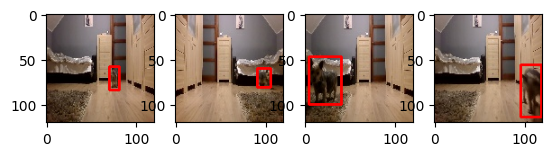

In [18]:
fig, ax = plt.subplots(1, 4)
for idx in range(4):
    image = batch[0][idx]
    bbox = batch[1][1][idx]
    cv2.rectangle(image,
        tuple(np.multiply(bbox[:2], [IMAGE_SIZE, IMAGE_SIZE]).astype(int)),
        tuple(np.multiply(bbox[2:], [IMAGE_SIZE, IMAGE_SIZE]).astype(int)),
        (255,0,0),
        2
    )
    ax[idx].imshow(image)

# 7. Build the detection model

In [19]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [20]:
def build_model():
    input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    vgg16 = VGG16(include_top=False)(input_layer)

    # classification model
    cl1 = GlobalMaxPooling2D()(vgg16)
    cl2 = Dense(2048, activation='relu')(cl1)
    cl3 = Dense(1, activation='sigmoid')(cl2)

    # bbox model
    bbox1 = GlobalMaxPooling2D()(vgg16)
    bbox2 = Dense(2048, activation='relu')(bbox1)
    bbox3 = Dense(4, activation='sigmoid')(bbox2)

    return Model(inputs=input_layer, outputs=[cl3, bbox3])

In [21]:
def bbox_loc_loss(true_bbox, pred_bbox):
    # calculate bbox top-point localization loss
    bbox_loc_loss = tf.reduce_sum(tf.square(true_bbox[:,:2] - pred_bbox[:,:2]))

    # calculate bbox width and height loss
    true_height = true_bbox[:,3] - true_bbox[:,1]
    pred_height = pred_bbox[:,3] - pred_bbox[:,1]

    true_width = true_bbox[:,2] - true_bbox[:,0]
    pred_width = pred_bbox[:,2] - pred_bbox[:,0]

    bbox_size_loss = tf.reduce_sum(tf.square(true_height - pred_height)
                                   + tf.square(true_width - pred_width))
    #return sum of above losses
    return bbox_loc_loss + bbox_size_loss

In [22]:
dog_detector = build_model()
loc_loss = bbox_loc_loss
class_loss = BinaryCrossentropy()
decay = (1.0 / 0.75 - 1) / len(train_set)
optimizer = Adam(learning_rate=0.0001, weight_decay=decay)

58889256/58889256 [==============================] - 2s 0us/step


In [23]:
def train_step(X, y):
    with tf.GradientTape() as tape:
        classes, bboxes = dog_detector(X, training=True)
        classes_loss = class_loss(y[0], classes)
        bboxes_loss = loc_loss(tf.cast(y[1], tf.float32), bboxes)
        total_loss = bboxes_loss + 0.5 * classes_loss
        grad = tape.gradient(total_loss, dog_detector.trainable_variables)
    optimizer.apply_gradients(zip(grad, dog_detector.trainable_variables))

    return classes_loss, bboxes_loss, total_loss

In [24]:
X, y = train_set.as_numpy_iterator().next()
train_step(X, y)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.6492349>,
 <tf.Tensor: shape=(), dtype=float32, numpy=16.596952>,
 <tf.Tensor: shape=(), dtype=float32, numpy=16.92157>)

In [25]:
test = test_set.as_numpy_iterator()

def draw_rect(image, bbox, color):
    image_copy = np.copy(image)
    cv2.rectangle(
        image_copy,
        tuple(np.multiply(bbox[:2], [IMAGE_SIZE, IMAGE_SIZE]).astype(int)),
        tuple(np.multiply(bbox[2:], [IMAGE_SIZE, IMAGE_SIZE]).astype(int)),
        color, 2
    )
    return image_copy

# below function plots real detections and detections made by our neural network
def test_model_detections(epoch):
    X, y_true = test.next()
    y_pred = dog_detector(X)
    fig, ax = plt.subplots(2, 4)
    ax[0][0].set_title('Computer detections')
    ax[1][0].set_title('Human detections')
    fig.tight_layout()


    for idx in range(4):
        dog_prob = y_pred[0][idx]
        bbox_pred = y_pred[1][idx]
        bbox_true = y_true[1][idx]

        #draw predicted bbox if probability that there is a dog > 0.5
        if dog_prob > 0.5:
            pred_detection_image = draw_rect(X[idx], bbox_pred, (0, 255, 0))
            ax[0][idx].imshow(pred_detection_image)
        else:
            ax[0][idx].imshow(X[idx])

        # draw real bbox
        true_detection_image = draw_rect(X[idx], bbox_true, (0, 255, 0))
        ax[1][idx].imshow(true_detection_image)

    plt.show()
    plt.close()


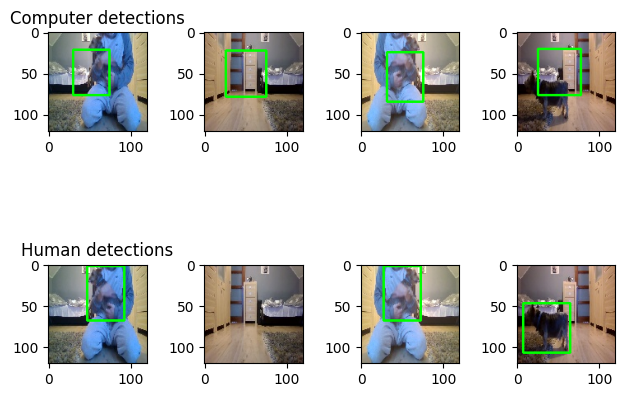

In [26]:
test_model_detections(1)

Epoch 0: class loss: 0.19390565156936646, bboxes loss: 2.0304572582244873, total loss: 2.1274101734161377


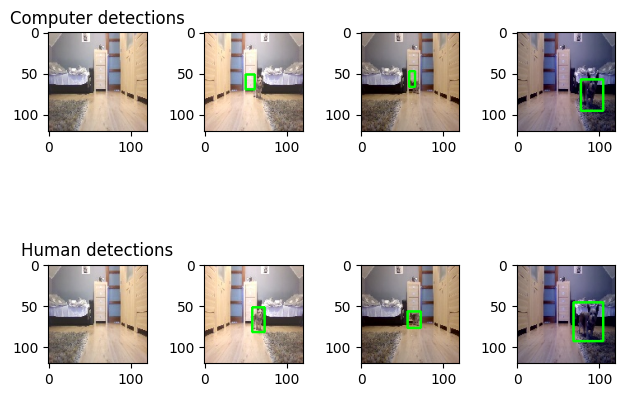

Epoch 1: class loss: 0.019906431436538696, bboxes loss: 0.3537256419658661, total loss: 0.36367887258529663
Epoch 2: class loss: 0.0026797372847795486, bboxes loss: 0.140258327126503, total loss: 0.1415981948375702
Epoch 3: class loss: 0.001580638810992241, bboxes loss: 0.08284541964530945, total loss: 0.08363573998212814
Epoch 4: class loss: 0.0002715434820856899, bboxes loss: 0.04300582781434059, total loss: 0.043141596019268036
Epoch 5: class loss: 0.0001178499951492995, bboxes loss: 0.028323639184236526, total loss: 0.028382563963532448
Epoch 6: class loss: 6.162744830362499e-05, bboxes loss: 0.0227633249014616, total loss: 0.02279413864016533
Epoch 7: class loss: 4.276671097613871e-05, bboxes loss: 0.019270796328783035, total loss: 0.019292179495096207
Epoch 8: class loss: 2.908395072154235e-05, bboxes loss: 0.015022831968963146, total loss: 0.015037372708320618
Epoch 9: class loss: 2.1654952433891594e-05, bboxes loss: 0.015668300911784172, total loss: 0.015679126605391502
Epoch 1

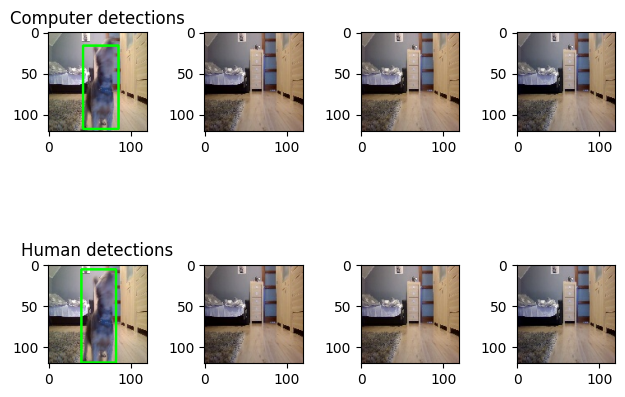

Epoch 11: class loss: 1.4799373275309335e-05, bboxes loss: 0.015335221774876118, total loss: 0.015342623926699162
Epoch 12: class loss: 1.3970407053420786e-05, bboxes loss: 0.015445481985807419, total loss: 0.015452466905117035
Epoch 13: class loss: 1.2071389392076526e-05, bboxes loss: 0.01255660317838192, total loss: 0.012562638148665428
Epoch 14: class loss: 9.086051250051241e-06, bboxes loss: 0.01268072985112667, total loss: 0.012685272842645645
Epoch 15: class loss: 7.707809345447458e-06, bboxes loss: 0.010911531746387482, total loss: 0.010915386490523815
Epoch 16: class loss: 7.475250640709419e-06, bboxes loss: 0.011102892458438873, total loss: 0.01110663078725338
Epoch 17: class loss: 7.071324034768622e-06, bboxes loss: 0.009739082306623459, total loss: 0.009742618538439274
Epoch 18: class loss: 4.765716312249424e-06, bboxes loss: 0.007102231029421091, total loss: 0.00710461288690567
Epoch 19: class loss: 5.58081455892534e-06, bboxes loss: 0.01456507109105587, total loss: 0.01456

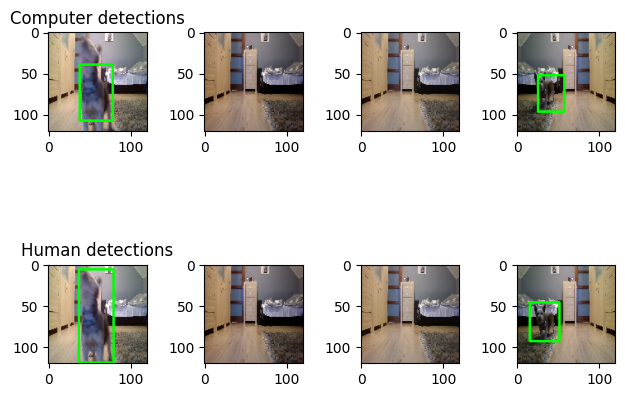

Epoch 21: class loss: 0.004078982397913933, bboxes loss: 0.0899139866232872, total loss: 0.09195348620414734
Epoch 22: class loss: 0.00014441141684073955, bboxes loss: 0.0256282277405262, total loss: 0.025700436905026436
Epoch 23: class loss: 6.645603571087122e-05, bboxes loss: 0.01582048088312149, total loss: 0.01585370860993862
Epoch 24: class loss: 3.671048398246057e-05, bboxes loss: 0.01019902154803276, total loss: 0.010217376984655857
Epoch 25: class loss: 2.4158873202395625e-05, bboxes loss: 0.007880997844040394, total loss: 0.007893078029155731
Epoch 26: class loss: 1.7441743693780154e-05, bboxes loss: 0.00726153701543808, total loss: 0.0072702569887042046
Epoch 27: class loss: 1.4031627870281227e-05, bboxes loss: 0.006859350949525833, total loss: 0.006866366136819124
Epoch 28: class loss: 1.0581751666904893e-05, bboxes loss: 0.005931895691901445, total loss: 0.005937187001109123
Epoch 29: class loss: 9.02918054634938e-06, bboxes loss: 0.005812293849885464, total loss: 0.0058168

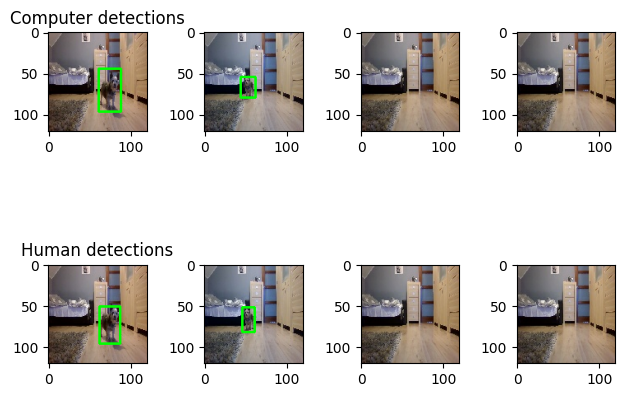

Epoch 31: class loss: 5.942507868894609e-06, bboxes loss: 0.004928246606141329, total loss: 0.004931217525154352
Epoch 32: class loss: 5.846522526553599e-06, bboxes loss: 0.006202679593116045, total loss: 0.006205603014677763
Epoch 33: class loss: 4.68874532089103e-06, bboxes loss: 0.005338069051504135, total loss: 0.005340413190424442
Epoch 34: class loss: 4.0450972846883815e-06, bboxes loss: 0.005147839896380901, total loss: 0.005149862263351679
Epoch 35: class loss: 4.14987471231143e-06, bboxes loss: 0.0076297917403280735, total loss: 0.0076318662613630295
Epoch 36: class loss: 3.685169758682605e-06, bboxes loss: 0.005322222597897053, total loss: 0.0053240652196109295
Epoch 37: class loss: 3.1736008168081753e-06, bboxes loss: 0.00558381387963891, total loss: 0.005585400387644768
Epoch 38: class loss: 3.0681173939228756e-06, bboxes loss: 0.006890833377838135, total loss: 0.006892367731779814
Epoch 39: class loss: 2.9710001854255097e-06, bboxes loss: 0.006263538729399443, total loss: 

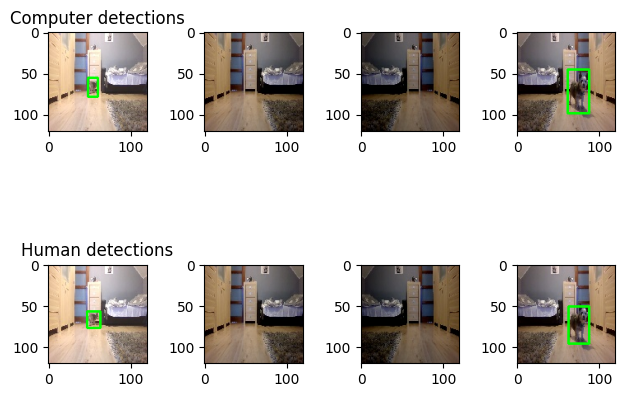

Epoch 41: class loss: 2.7439361929282313e-06, bboxes loss: 0.009482622146606445, total loss: 0.009483993984758854
Epoch 42: class loss: 2.58579348155763e-06, bboxes loss: 0.006032843142747879, total loss: 0.006034135818481445
Epoch 43: class loss: 1.8294526853424031e-06, bboxes loss: 0.004042597953230143, total loss: 0.004043512977659702
Epoch 44: class loss: 1.909329284899286e-06, bboxes loss: 0.008557822555303574, total loss: 0.008558777160942554
Epoch 45: class loss: 2.0068496269232128e-06, bboxes loss: 0.00938842911273241, total loss: 0.009389432147145271
Epoch 46: class loss: 1.5976605709511205e-06, bboxes loss: 0.004123094491660595, total loss: 0.004123893100768328
Epoch 47: class loss: 1.2374059679132188e-06, bboxes loss: 0.0029354023281484842, total loss: 0.002936020726338029
Epoch 48: class loss: 1.0972847803714103e-06, bboxes loss: 0.0034072541166096926, total loss: 0.003407802665606141
Epoch 49: class loss: 9.968850918085082e-07, bboxes loss: 0.004956959281116724, total loss

KeyboardInterrupt: ignored

In [27]:
epochs = 200
total_epochs_loss = []

for epoch in range(epochs):
    classes_losses, bboxes_losses, total_losses = [], [], []

    for step, (x_batch_train, y_batch_train) in enumerate(train_set):
        classes_loss, bboxes_loss, total_loss = train_step(x_batch_train, y_batch_train)
        classes_losses.append(classes_loss)
        bboxes_losses.append(bboxes_loss)
        total_losses.append(total_loss)

    total_epochs_loss.append(np.mean(total_losses))

    print(f'Epoch {epoch}: class loss: {np.mean(classes_losses)}, bboxes loss: {np.mean(bboxes_losses)}, total loss: {np.mean(total_losses)}')

    if epoch % 10 == 0:
        test_model_detections(epoch)

    if epoch % 5 == 0 and epoch != 0:
        dog_detector.save_weights(f'detector_weights/epoch{epoch}')